<img src="https://raw.githubusercontent.com/harmonize-tools/socio4health/main/docs/source/_static/image.png" alt="image info" height="100" width="100"/>


# Harmonization of data

**Run the tutorial via free cloud platforms:** [![badge](https://img.shields.io/badge/launch-binder-E66581.svg?logo=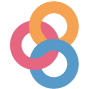)](https://github.com/harmonize-tools/socio4health/blob/main/docs/source/notebooks/extractor.ipynb) <a target="_blank" href="https://colab.research.google.com/github/harmonize-tools/socio4health/blob/main/docs/source/notebooks/extractor.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



This notebook provides you with a tutorial on how to process the sociodemographic and economic data from online data sources from  **Brazil**. This tutorial assumes you have an **intermediate** or **advanced** understanding of **Python** and data manipulation.

## Setting up the enviornment

To run this notebook, you need to have the following prerequisites:

- Python 3.10+

Additionally, you need to install the `socio4health` and `pandas` package, which can be done using ``pip``:



In [ ]:
!pip install socio4health pandas -q

## Import Libraries

In [ ]:
import pandas as pd
from socio4health import Extractor
from socio4health.enums.data_info_enum import BraColnamesEnum, BraColspecsEnum
from socio4health.harmonizer import Harmonizer
from socio4health.utils import harmonizer_utils
import tqdm as tqdm


## Extracting data from Brazil

In this example, we will extract the Brazilian National Continuous Household Sample Survey (**PNADC**) for the year 2024 from the Brazilian Institute of Geography and Statistics (**IBGE**) website.

In [ ]:
bra_online_extractor = Extractor(input_path="https://ftp.ibge.gov.br/Trabalho_e_Rendimento/Pesquisa_Nacional_por_Amostra_de_Domicilios_continua/Trimestral/Microdados/2024/", down_ext=['.txt','.zip'], is_fwf=True, colnames=BraColnamesEnum.PNADC.value, colspecs=BraColspecsEnum.PNADC.value, output_path="../data", depth=0)

## Providing the raw dictionary

We need to provide a **raw dictionary** to the **harmonizer** that contains the column names and their corresponding data types. This is necessary for the harmonization process, as it allows the harmonizer to understand the structure of the data. To know more about how to construct the raw dictionary, you can check the [documentation](https://harmonize-tools.github.io/socio4health/dictionary.html).

In [ ]:
raw_dict = pd.read_excel('raw_dictionary.xlsx')

The raw dictionary is then standardized using the `standardize_dict` method, which ensures that the dictionary is in a consistent format, making it easier to work with during the harmonization process.

In [1]:
dic = harmonizer_utils.standardize_dict(raw_dict)

NameError: name 'harmonizer_utils' is not defined

Additionally, the content of columns of the dictionary can be translated  into English using `translate_column` function from `harmonizer_utils` module. Translation is performed for facilitate the understanding and processing of the data.

<div style="border-left: 4px solid #e74c3c; background: #fdecea; color: #222; padding: 0.5em 1em; margin: 1em 0; display: flex; align-items: center;">
  <span style="font-size: 20px; margin-right: 10px;">⚠️</span>
  <div>
    <strong>Warning:</strong> <code>translate_column</code> method from <code>harmonizer_utils</code> module uses the <a href="https://huggingface.co/transformers/main_classes/pipelines.html#translation" target="_blank">Hugging Face translation pipeline</a> to translate the content of the specified columns. The translation may take some time depending on the <strong>size</strong> of the dictionary and the <strong> number of columns </strong> to be translated. It is recommended to use this method <strong> only </strong> if you need the content of the columns in English for further processing or analysis.
  </div>
</div>

In [ ]:
dic = harmonizer_utils.translate_column(dic, "question", language="en")
dic = harmonizer_utils.translate_column(dic, "description", language="en")
dic = harmonizer_utils.translate_column(dic, "possible_answers", language="en")


The `classify_rows` method is then used to classify the rows of the standardized dictionary based on the content of the specified columns. This classification helps in organizing the data and making it easier to work with during the harmonization process. The `MODEL_PATH` parameter specifies the path to a pre-trained model that is used for classification. You can provide your own model or use the default one provided in the `files` folder. The model is a **fine-tuned BERT model** for text classification. You can find more details about the model in the [documentation](https://harmonize-tools.github.io/socio4health/socio4health.utils.harmonizer_utils.classify_rows.html#socio4health.utils.harmonizer_utils.classify_rows).

In [ ]:
dic = harmonizer_utils.classify_rows(dic, "question_en", "description_en", "possible_answers_en",
                                     new_column_name="category",
                                     MODEL_PATH="files/bert_finetuned_classifier")

## Extracting the data
The `extract` method of the `Extractor` class is used retrieve the data from the specified input path. It returns a list of dataframes, each dataframe corresponding to a file extracted from the path.

In [ ]:
dfs = bra_online_extractor.extract()

## Harmonizing the data
First, we need to create an instance of the `Harmonizer` class.

In [ ]:
har = Harmonizer()


After the dictionary is standardized and translated, it can be used to harmonize the data. For this, set the `dict_df` attribute of the `Harmonizer` instance to the standardized dictionary. This allows the harmonizer to use the information from the dictionary to process the dataframes.

In [ ]:
har.dict_df = dic

Next, we can set the parameters for the harmonization process. The `similarity_threshold` parameter is used to set the threshold for the similarity among column names. The `nan_threshold` parameter is used to set the threshold for the number of `NaN` values allowed in a column. If a column has more `NaN` values than the specified threshold, it will be dropped from the final dataframe.



In [ ]:
har.similarity_threshold = 0.9
har.nan_threshold = 1


The `vertical_merge` method is used to merge the dataframes **vertically. This means that the dataframes will be concatenated along the rows, and the columns will be aligned based on their names. Available columns can be obtained using the `get_available_columns` method, which returns a list of column names that are present in all dataframes after the vertical merge.

In [ ]:
dfs = har.vertical_merge(dfs)
available_columns = har.get_available_columns(dfs)

For the selection of rows from the data, we can use the `data_selector` method. To use this method we first need to assign the categories of our interest, which can either be one or a set of the following categories:  `Business`, `Educations`, `Fertility`, `Housing`, `Identification`, `Migration`, `Nonstandard job`, `Social Security` .This method allows us to **select specific rows** from the data based on the values in a specified column. The `key_col` parameter specifies the column to be used for selection, and the `key_val` parameter specifies the values to be selected. In this case, we will select rows where the value in the `DPTO` column is equal to `25`, which corresponds to the state of São Paulo.

In [ ]:
har.categories = ["Business"]
har.key_col = 'DPTO'
har.key_val = ['25']
filtered_ddfs = har.data_selector(dfs)

Finally, we can **join** the filtered dataframes into a **single dataframe** using the `join_data` method. This method combines the data from the **filtered dataframes** into a **single dataframe**, aligning the columns based on their names. The resulting dataframe will contain all the columns that are present in the filtered dataframes, and it will be ready for further analysis or **export** as a `CSV` file.

In [ ]:
joined_df = har.join_data(filtered_ddfs)
available_cols = joined_df.columns.tolist()
print(f"Available columns: {available_cols}")
print(f"Shape of the joined DataFrame: {joined_df.shape}")
print(joined_df.head())
joined_df.to_csv('data/GEIH_2022_harmonized.csv', index=False)